#### To run go to: https://www.kaggle.com/code/nikhileshmyanapuri/eeg-mental

In [1]:
##### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# I found that the eeg_recording28 doesn't have enough data,the date for drowsy is only 76800.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.io
import matplotlib.pyplot as plt
import os
from scipy import signal
from scipy.fft import fft, fftshift
from tensorflow.keras import Sequential
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

file_names=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_names.append(os.path.join(dirname, filename))
        #print(os.path.join(dirname, filename))
        
#print(file_names)
# each trial is about 54 mins


dict_keys(['eeg_record25', 'eeg_record26', 'eeg_record17', 'eeg_record3', 'eeg_record20', 'eeg_record13', 'eeg_record14', 'eeg_record10', 'eeg_record21', 'eeg_record19', 'eeg_record4', 'eeg_record18', 'eeg_record33', 'eeg_record27', 'eeg_record32', 'eeg_record24', 'eeg_record11', 'eeg_record6', 'eeg_record31', 'eeg_record12', 'eeg_record7', 'eeg_record5', 'eeg_record34'])

In [2]:
# build 4 order high pass filter
from scipy.signal import butter, lfilter, freqz   
# ----- ----- ----- -----    
def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    x = signal.filtfilt(b, a, data)
    y = signal.filtfilt(b, a, x)
    return y


In [3]:
#starting from Channel 3,/0,1,2,3
# The introduction of the data set in kaggle doesn't provide enough information.
#And we don't know which data are useful I have to plot all the channels.
#There are 14 channels, but the experimenter modified the headset.
#after removing the DC, the EEG amplitude should be around (-100,100).
#According to the plot, I think ['F7','F3','P7','O1','O2','P8','AF4'] are useful channels.
# fig, ax = plt.subplots(14,1)
# fig.set_figwidth(20)
# fig.set_figheight(50)
#fig.set_size_inches(10,10)
mat = scipy.io.loadmat(file_names[0])
data = mat['o']['data'][0,0]
FS = mat['o']['sampFreq'][0][0][0][0]
channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
# for i in range(14):
#     data_ave = data[5000:15000,i+3]-np.mean(data[5000:15000,i+3])
#     ax[i].plot(data_ave)
#     ax[i].set_title(channels[i])
#     ax[i].set_ylim(-100,100)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#F7,F3,P7,O1,O2,P8,AF4
useful_channels=[3,16]
useful_channels_names=['AF3','AF4']
# fig,ax = plt.subplots(7)
# fig.set_size_inches(20,40)
# j=0
# for i in useful_channels:
#     data_ave = data[5000:15000,i]-np.mean(data[5000:15000,i])
#     ax[j].plot(data_ave)
#     ax[j].set_ylim(-200,200)
#     ax[j].set_title(channels[i-3])
#     j=j+1

focus data from 0-10 mins,unfocus data from 10_20 mins, and drowsy 20-30 mins
The first two files is the data of practicing, so I am going to use the last 5 files from each participant.
There are 24 files expect the subject 5 can't record his 7th recording.

In [5]:
marker=128*60*10
#delete file #28 because it doesnot have enough data
useful_file_index = [3,4,5,6,7,10,11,12,13,14,17,18,19,20,21,24,25,26,27,31,32,33,34]
#useful_file_index = np.arange(1,35)
chan_num=7
trail_names=[]
data_focus={}
data_unfocus={}
data_drowsy={}
focus={}
unfocus={}
drowsy={}
#for i in useful_file_index:
i=1
for index,filename in enumerate(filenames):
    if int(filename.split('d')[1].split('.')[0]) in useful_file_index:
        mat = scipy.io.loadmat(file_names[index])
        trail_names.append(filename.split('.')[0])
        data_focus[trail_names[-1]]=mat['o']['data'][0,0][0:marker,useful_channels].copy()
        data_unfocus[trail_names[-1]]=mat['o']['data'][0,0][marker:2*marker,useful_channels].copy()
        data_drowsy[trail_names[-1]]=mat['o']['data'][0,0][2*marker:3*marker,useful_channels].copy()
        focus[trail_names[-1]]=mat['o']['data'][0,0][0:marker,useful_channels].copy()
        unfocus[trail_names[-1]]=mat['o']['data'][0,0][marker:2*marker,useful_channels].copy()
        drowsy[trail_names[-1]]=mat['o']['data'][0,0][2*marker:3*marker,useful_channels].copy()

In [6]:
data_focus.keys()

dict_keys(['eeg_record25', 'eeg_record26', 'eeg_record17', 'eeg_record3', 'eeg_record20', 'eeg_record13', 'eeg_record14', 'eeg_record10', 'eeg_record21', 'eeg_record19', 'eeg_record4', 'eeg_record18', 'eeg_record33', 'eeg_record27', 'eeg_record32', 'eeg_record24', 'eeg_record11', 'eeg_record6', 'eeg_record31', 'eeg_record12', 'eeg_record7', 'eeg_record5', 'eeg_record34'])

In [7]:
data_focus['eeg_record3']

array([[4440.51282051, 4024.1025641 ],
       [4440.51282051, 4017.94871795],
       [4440.51282051, 4018.97435897],
       ...,
       [4444.1025641 , 4151.28205128],
       [4444.1025641 , 4134.87179487],
       [4442.05128205, 4125.64102564]])

In [8]:
# High Pass 0.16HZ
row, col = data_focus['eeg_record3'].shape
for name in trail_names:
    for i in range(col):
        data_focus[name][:,i]=butter_highpass_filter(data_focus[name][:,i], 0.16, 128, 4)
        data_unfocus[name][:,i]=butter_highpass_filter(data_unfocus[name][:,i], 0.16, 128, 4)
        data_drowsy[name][:,i]=butter_highpass_filter(data_drowsy[name][:,i], 0.16, 128, 4)
        #print(name,data_drowsy[name][:,i].shape)

In [9]:
col

2

In [10]:
feature_names = []
freq_range=np.arange(0.5,18.5,0.5)
symb='_'
#useful_channels_names=['AF3','AF4']
for index,channel in enumerate(useful_channels_names):
    for freq in freq_range:
        feature_names.append(channel+symb+str(freq))
feature_names

['AF3_0.5',
 'AF3_1.0',
 'AF3_1.5',
 'AF3_2.0',
 'AF3_2.5',
 'AF3_3.0',
 'AF3_3.5',
 'AF3_4.0',
 'AF3_4.5',
 'AF3_5.0',
 'AF3_5.5',
 'AF3_6.0',
 'AF3_6.5',
 'AF3_7.0',
 'AF3_7.5',
 'AF3_8.0',
 'AF3_8.5',
 'AF3_9.0',
 'AF3_9.5',
 'AF3_10.0',
 'AF3_10.5',
 'AF3_11.0',
 'AF3_11.5',
 'AF3_12.0',
 'AF3_12.5',
 'AF3_13.0',
 'AF3_13.5',
 'AF3_14.0',
 'AF3_14.5',
 'AF3_15.0',
 'AF3_15.5',
 'AF3_16.0',
 'AF3_16.5',
 'AF3_17.0',
 'AF3_17.5',
 'AF3_18.0',
 'AF4_0.5',
 'AF4_1.0',
 'AF4_1.5',
 'AF4_2.0',
 'AF4_2.5',
 'AF4_3.0',
 'AF4_3.5',
 'AF4_4.0',
 'AF4_4.5',
 'AF4_5.0',
 'AF4_5.5',
 'AF4_6.0',
 'AF4_6.5',
 'AF4_7.0',
 'AF4_7.5',
 'AF4_8.0',
 'AF4_8.5',
 'AF4_9.0',
 'AF4_9.5',
 'AF4_10.0',
 'AF4_10.5',
 'AF4_11.0',
 'AF4_11.5',
 'AF4_12.0',
 'AF4_12.5',
 'AF4_13.0',
 'AF4_13.5',
 'AF4_14.0',
 'AF4_14.5',
 'AF4_15.0',
 'AF4_15.5',
 'AF4_16.0',
 'AF4_16.5',
 'AF4_17.0',
 'AF4_17.5',
 'AF4_18.0']

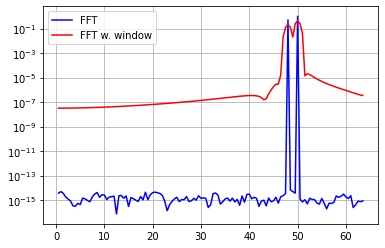

In [326]:
from scipy.fft import fft, fftfreq
import numpy as np
# Number of sample points
N = 256
# sample spacing
T = 1.0 / 128.0
x = np.linspace(0.0, N*T, N, endpoint=False)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = fft(y)
from scipy.signal import blackman
N=256
w = blackman(N)
ywf = fft(y*w)
xf = fftfreq(N, T)[:N//2]
import matplotlib.pyplot as plt
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
plt.semilogy(xf[1:N//2], 2.0/N * np.abs(ywf[1:N//2]), '-r')
plt.legend(['FFT', 'FFT w. window'])
plt.grid()
plt.show()

In [29]:
ywf.shape

(256,)

In [23]:
data_focus['eeg_record25'][:,1].shape[0]/256

300.0

In [11]:
# # STFT was then calculated at a time step of 1 s producing a set of time-varying DFT 
# # amplitudes X STFT (t,ω) at 1s intervals within each input EEG channel.
# t_win = np.arange(0,128)
# M = 128
# window_blackman=0.42-0.5*np.cos((2*np.pi*t_win)/(M-1))+0.08*np.cos((4*np.pi*t_win)/(M-1))#window_blackman = signal.windows.blackmanharris(128)

# #col is 7
# power_focus = {}
# for name in trail_names:
#     power_focus[name]=np.zeros([col,513,601])
    
# power_unfocus = {}
# for name in trail_names:
#     power_unfocus[name]=np.zeros([col,513,601])
    
# power_drowsy = {}
# for name in trail_names:
#     power_drowsy[name]=np.zeros([col,513,601])

# #the output of the stft is 513*601,1 second data will produce 1 column of data,there are 601
# for name in trail_names:
#     for i in range(col):
#         f, t,y1=scipy.signal.stft(data_focus[name][:,i],fs=128, window=window_blackman, nperseg=128, 
#                       noverlap=0, nfft=1024, detrend=False,return_onesided=True, boundary='zeros',
#                       padded=True)
#         f, t,y2=scipy.signal.stft(data_unfocus[name][:,i],fs=128, window=window_blackman, nperseg=128, 
#                       noverlap=0, nfft=1024, detrend=False,return_onesided=True, boundary='zeros',
#                       padded=True)
#         f, t,y3=scipy.signal.stft(data_drowsy[name][:,i],fs=128, window=window_blackman, nperseg=128, 
#                       noverlap=0, nfft=1024, detrend=False,return_onesided=True, boundary='zeros',
#                       padded=True)
#         power_focus[name][i,:,:]=(np.abs(y1))**2
#         power_unfocus[name][i,:,:]=(np.abs(y2))**2
#         power_drowsy[name][i,:,:]=(np.abs(y3))**2

# STFT was then calculated at a time step of 1 s producing a set of time-varying DFT 
# amplitudes X STFT (t,ω) at 1s intervals within each input EEG channel.
# t_win = np.arange(0,128)
# M = 128
# window_blackman=0.42-0.5*np.cos((2*np.pi*t_win)/(M-1))+0.08*np.cos((4*np.pi*t_win)/(M-1))#window_blackman = signal.windows.blackmanharris(128)
from scipy.signal import blackman
# Number of sample points
N = 256
# sample spacing
T = 1.0 / 128.0

w = blackman(N)

#col is 2
power_focus = {}
for name in trail_names:
    power_focus[name]=np.zeros([col,36,300])
    
power_unfocus = {}
for name in trail_names:
    power_unfocus[name]=np.zeros([col,36,300])
    
power_drowsy = {}
for name in trail_names:
    power_drowsy[name]=np.zeros([col,36,300])

#the output of the stft is 513*601,1 second data will produce 1 column of data,there are 601
for name in trail_names:
    for i in range(col):
        for j in range(300):
            y1=fft(data_focus[name][:,i][j*256:(j+1)*256]*w)
            y2=fft(data_unfocus[name][:,i][j*256:(j+1)*256]*w)
            y3=fft(data_drowsy[name][:,i][j*256:(j+1)*256]*w)
            power_focus[name][i,:,j]=2.0/N * np.abs(y1[0:36])
            power_unfocus[name][i,:,j]=2.0/N * np.abs(y2[0:36])
            power_drowsy[name][i,:,j]=2.0/N * np.abs(y3[0:36])



In [12]:
print(power_focus['eeg_record3'][0,:,:])

[[0.71053898 1.17811914 0.15067691 ... 0.02722622 0.17404109 0.6598754 ]
 [0.36550645 1.45488995 0.33244947 ... 0.06417974 0.22941623 0.60764054]
 [0.27656636 1.63429642 0.39851552 ... 0.087196   0.20774778 0.41745413]
 ...
 [0.55181325 0.22630038 0.1622191  ... 0.04568739 0.06431496 0.17935617]
 [0.61046591 0.24464624 0.09830927 ... 0.06184841 0.13164341 0.1946513 ]
 [0.70702985 0.12039931 0.03904226 ... 0.08754573 0.12331277 0.16069688]]


In [13]:
print(power_focus['eeg_record3'][1,:,:])

[[ 5.82830247 54.46831967 22.33378031 ... 23.77497678 11.75542457
  35.06503662]
 [20.65149835 46.32956873 16.21687312 ... 16.2651683   8.7097587
  34.62207144]
 [24.27087337 22.78277533  7.3140266  ...  6.59779695  1.23816874
  20.10189379]
 ...
 [ 1.02815257  0.80378647  0.24394307 ...  0.30384783  0.38674464
   0.61645193]
 [ 1.34584056  0.68175579  0.52086767 ...  0.24511065  0.47402863
   0.61446738]
 [ 1.53263307  0.75631813  0.48807656 ...  0.40473149  0.39863387
   0.42274069]]


In [340]:
power_focus['eeg_record33'][0,:,:]

array([[0.58595936, 0.24387291, 2.12683825, ..., 0.531493  , 0.25935554,
        1.19236533],
       [1.36163418, 2.15540008, 2.38024258, ..., 1.1491318 , 0.79605665,
        1.02907348],
       [0.96666977, 1.18487811, 1.49716379, ..., 1.04367352, 0.78057279,
        0.3469228 ],
       ...,
       [0.23015927, 0.16206308, 0.28624466, ..., 0.26002184, 0.18017338,
        0.05897799],
       [0.06770279, 0.11273217, 0.09556083, ..., 0.31454114, 0.18783779,
        0.10684232],
       [0.13744115, 0.0705755 , 0.07933554, ..., 0.30145706, 0.07320653,
        0.08346765]])

In [315]:
# combine bins into 0.5HZ, and keep 0-18 HZ.

num=[]

power_focus_bin = {}
for name in trail_names:
    power_focus_bin[name]=np.zeros([2,36,601])
    
power_unfocus_bin = {}
for name in trail_names:
    power_unfocus_bin[name]=np.zeros([2,36,601])
    
power_drowsy_bin = {}
for name in trail_names:
    power_drowsy_bin[name]=np.zeros([2,36,601])

for name in trail_names:
    for chn in range(col):
        j=0
        for i in range(1,144,4):
            power_focus_bin[name][chn,j,:]=np.average(power_focus[name][chn,i:i+4,:],axis=0)
            power_unfocus_bin[name][chn,j,:]=np.average(power_unfocus[name][chn,i:i+4,:],axis=0)
            power_drowsy_bin[name][chn,j,:]=np.average(power_drowsy[name][chn,i:i+4,:],axis=0)
            #print(np.average(power_drowsy[name][chn,i:i+4,:],axis=0).shape)
            #if name=='eeg_record3':
            #    if chn==0:
            #        num.append((f[i:i+4]))
            #    print(j)
            j=j+1
            
#print(num)    
#print(len(num))

ValueError: could not broadcast input array from shape (300,) into shape (601,)

In [58]:
# # avarage over 15 seconds running window.

# power_focus_ave = {}
# for name in trail_names:
#     power_focus_ave[name]=np.zeros([2,36,585])
    
# power_unfocus_ave = {}
# for name in trail_names:
#     power_unfocus_ave[name]=np.zeros([2,36,585])
    
# power_drowsy_ave = {}
# for name in trail_names:
#     power_drowsy_ave[name]=np.zeros([2,36,585])

# for name in trail_names:
#     for chn in range(col):
#         j=0
#         for k in range(0,585):
#             power_focus_ave[name][chn,:,j]=np.average(power_focus_bin[name][chn,:,k:k+15],axis=1)
#             power_unfocus_ave[name][chn,:,j]=np.average(power_unfocus_bin[name][chn,:,k:k+15],axis=1)
#             power_drowsy_ave[name][chn,:,j]=np.average(power_drowsy_bin[name][chn,:,k:k+15],axis=1)
#             #print(np.average(power_drowsy_bin[name][chn,:,k:k+15],axis=1).shape)
#             j=j+1

# avarage over 15 seconds running window.

power_focus_ave = {}
for name in trail_names:
    power_focus_ave[name]=np.zeros([2,36,292])
    
power_unfocus_ave = {}
for name in trail_names:
    power_unfocus_ave[name]=np.zeros([2,36,292])
    
power_drowsy_ave = {}
for name in trail_names:
    power_drowsy_ave[name]=np.zeros([2,36,292])

for name in trail_names:
    for chn in range(col):
        j=0
        for k in range(0,292):
            power_focus_ave[name][chn,:,j]=np.average(power_focus[name][chn,:,k:k+8],axis=1)
            power_unfocus_ave[name][chn,:,j]=np.average(power_unfocus[name][chn,:,k:k+8],axis=1)
            power_drowsy_ave[name][chn,:,j]=np.average(power_drowsy[name][chn,:,k:k+8],axis=1)
            #print(np.average(power_drowsy_bin[name][chn,:,k:k+15],axis=1).shape)
            j=j+1

In [14]:
# Turn the data into a vector 
#[72,300]

svm_focus = {}
for name in trail_names:
    svm_focus[name]=np.zeros([72,300])
    
svm_unfocus = {}
for name in trail_names:
    svm_unfocus[name]=np.zeros([72,300])
    
svm_drowsy = {}
for name in trail_names:
    svm_drowsy[name]=np.zeros([72,300])

for name in trail_names:
    for j in range(300):      
        svm_focus[name][:,j]=power_focus[name][:,:,j].reshape(1,-1)
        svm_unfocus[name][:,j]=power_unfocus[name][:,:,j].reshape(1,-1)
        svm_drowsy[name][:,j]=power_drowsy[name][:,:,j].reshape(1,-1)
    svm_focus[name]=10*np.log(svm_focus[name])
    svm_unfocus[name]=10*np.log(svm_unfocus[name])
    svm_drowsy[name]=10*np.log(svm_drowsy[name])
# now, we get the svm vector 252*585 252 rows


In [15]:
svm_focus['eeg_record33'].shape

(72, 300)

# The result seems like it's seperatable between subjects at 11HZ.

# ***************          ******* 
# from above, I think I got the data ready for SVM processing.
# There are some ideas:
# 1. before SVM, I will use PCA first, then SVM.
# training data, choose what kind of data to do traning? practice data? or choose 1 day data or some columns from each recording?
# I will label the data into 3 classes. /
# focus-------  0/
# unfocus-----  1/
# drowsy------  2/
# in the paper, they use frequency 1-5HZ, 5-10HZ,10-15HZ,so I need to pay attention to which index coresponding to 1HZ.

#let me take subjetct 1 for an experiment.
#I will concatenate 5 files of each participant with 3 states,file number is the following.
{3,4,5,6,7}

In [16]:
#--------0
label_focus = [0]*300
#--------1
label_unfocus = [1]*300
#--------2
label_drowsy = [2]*300

#subject is the variable for all participants

subj1_files={'eeg_record3','eeg_record4','eeg_record5','eeg_record6','eeg_record7'}
subj2_files={'eeg_record10','eeg_record11','eeg_record12','eeg_record13','eeg_record14'}
subj3_files={'eeg_record17','eeg_record18','eeg_record19','eeg_record20','eeg_record21'}
subj4_files={'eeg_record24','eeg_record25','eeg_record26','eeg_record27'}
subj5_files={'eeg_record31','eeg_record32','eeg_record33','eeg_record34'}


useful_file_index = [3,4,5,6,7,10,11,12,13,14,17,18,19,20,21,24,25,26,27,31,32,33,34]

In [17]:
# I will try to use the data from all participants to train the model
target=[]
subj=np.array([]).reshape(72,0).copy()
for name in trail_names:
    subj=np.concatenate((subj,svm_focus[name]), axis=1)
    subj=np.concatenate((subj,svm_unfocus[name]), axis=1)
    subj=np.concatenate((subj,svm_drowsy[name]), axis=1)  
    target = target+label_focus+label_unfocus+label_drowsy
subj=subj.T
target = np.array(target)

In [18]:
subj.shape

(20700, 72)

In [29]:
# This part I only train the data for subject1
target1=[]
subj1=np.array([]).reshape(72,0).copy()
for name in subj1_files:
    subj1=np.concatenate((subj1,svm_focus[name]), axis=1)
    subj1=np.concatenate((subj1,svm_unfocus[name]), axis=1)
    subj1=np.concatenate((subj1,svm_drowsy[name]), axis=1)  
    target1 = target1+label_focus+label_unfocus+label_drowsy
subj1=subj1.T
target1 = np.array(target1)

In [30]:
print(subj1.shape)
print(len(target1))

(8775, 72)
8775


In [31]:
target2=[]
subj2=np.array([]).reshape(72,0).copy()
for name in subj2_files:
    subj2=np.concatenate((subj2,svm_focus[name]), axis=1)
    subj2=np.concatenate((subj2,svm_unfocus[name]), axis=1)
    subj2=np.concatenate((subj2,svm_drowsy[name]), axis=1)  
    target2 = target2+label_focus+label_unfocus+label_drowsy
subj2=subj2.T
target2 = np.array(target2)

In [32]:
target3=[]
subj3=np.array([]).reshape(72,0).copy()
for name in subj3_files:
    subj3=np.concatenate((subj3,svm_focus[name]), axis=1)
    subj3=np.concatenate((subj3,svm_unfocus[name]), axis=1)
    subj3=np.concatenate((subj3,svm_drowsy[name]), axis=1)  
    target3 = target3+label_focus+label_unfocus+label_drowsy
subj3=subj3.T
target3 = np.array(target3)

In [33]:
target4=[]
subj4=np.array([]).reshape(72,0).copy()
for name in subj4_files:
    subj4=np.concatenate((subj4,svm_focus[name]), axis=1)
    subj4=np.concatenate((subj4,svm_unfocus[name]), axis=1)
    subj4=np.concatenate((subj4,svm_drowsy[name]), axis=1)  
    target4 = target4+label_focus+label_unfocus+label_drowsy
subj4=subj4.T
target4 = np.array(target4)

In [34]:
target5=[]
subj5=np.array([]).reshape(72,0).copy()
for name in subj5_files:
    subj5=np.concatenate((subj5,svm_focus[name]), axis=1)
    subj5=np.concatenate((subj5,svm_unfocus[name]), axis=1)
    subj5=np.concatenate((subj5,svm_drowsy[name]), axis=1)  
    target5 = target5+label_focus+label_unfocus+label_drowsy
subj5=subj5.T
target5 = np.array(target5)

In [35]:
print('length of the target:',len(target))
print('the shape of the data from the subject1:', subj.shape)

length of the target: 40365
the shape of the data from the subject1: (40365, 72)


In [19]:
subj.shape

(20700, 72)

In [20]:
n_past=8
subj_new=[]
for i in range(n_past ,len(subj)):
    subj_new.append(subj[i-n_past:i,0:72])
subj_new=np.array(subj_new)

In [21]:
target_new=target[n_past:]

In [22]:
# Train the data from subj
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC

arr = np.arange(20692)
np.random.shuffle(arr)
data_train, data_test,data_train_target, data_test_target = subj_new[arr[:20000]],subj_new[arr[20000:]],target_new[arr[:20000]],target_new[arr[20000:]]
# scaler = preprocessing.StandardScaler().fit(data_train)
# X_train_scaled = scaler.transform(data_train)
# X_test_scaled = scaler.transform(data_test)



In [201]:
svm = SVC(kernel='rbf')
svm.fit(X_train_scaled,data_train_target)
print(f'The Score for Training data with SVM Model for subject1:',svm.score(X_train_scaled,data_train_target))
print(f'Score of For Test data with SVM Model for subject1 : {svm.score(X_test_scaled,data_test_target)}')

KeyboardInterrupt: 

In [23]:
from sklearn.preprocessing import OneHotEncoder
en=OneHotEncoder()
data_train_target1=en.fit_transform(data_train_target.reshape(-1,1))
data_test_target1=en.fit_transform(data_test_target.reshape(-1,1))

In [24]:
data_train_target1 = data_train_target1.toarray()
data_test_target1 = data_test_target1.toarray()

In [25]:
data_train_target.shape

(20000,)

In [26]:
data_train.shape

(20000, 8, 72)

In [284]:

nn=Sequential([
    tf.keras.layers.Dense(70,activation='relu'),
    tf.keras.layers.Dense(45,activation='relu'),
    tf.keras.layers.Dense(21,activation='relu'),
    tf.keras.layers.Dense(3,activation='sigmoid')
])
nn.compile(loss=tf.keras.losses.BinaryCrossentropy())
nn.fit(X_train_scaled,data_train_target1,epochs=30)

Epoch 1/30
624/624 [==============================] - 3s 3ms/step - loss: 0.4823
Epoch 2/30
624/624 [==============================] - 2s 3ms/step - loss: 0.3887
Epoch 3/30
624/624 [==============================] - 2s 3ms/step - loss: 0.3403
Epoch 4/30
624/624 [==============================] - 2s 3ms/step - loss: 0.3047
Epoch 5/30
624/624 [==============================] - 2s 3ms/step - loss: 0.2731
Epoch 6/30
624/624 [==============================] - 2s 3ms/step - loss: 0.2474
Epoch 7/30
624/624 [==============================] - 2s 3ms/step - loss: 0.2250
Epoch 8/30
624/624 [==============================] - 2s 3ms/step - loss: 0.2041
Epoch 9/30
624/624 [==============================] - 2s 3ms/step - loss: 0.1868
Epoch 10/30
624/624 [==============================] - 2s 3ms/step - loss: 0.1702
Epoch 11/30
624/624 [==============================] - 2s 3ms/step - loss: 0.1546
Epoch 12/30
624/624 [==============================] - 2s 4ms/step - loss: 0.1433
Epoch 13/30
624/624 [====

In [28]:
# nn=Sequential([
#     tf.keras.layers.LSTM(70,return_sequences=True, input_shape= (8,72)),
#     tf.keras.layers.LSTM(45,return_sequences=False,activation='relu'),
#     tf.keras.layers.Dense(24,activation='relu'),
#     tf.keras.layers.Dense(3,activation='sigmoid')
# ])
# nn.compile(loss=tf.keras.losses.BinaryCrossentropy())
# nn.fit(data_train,data_train_target1,epochs=35)

nn=Sequential([
    tf.keras.layers.LSTM(45,return_sequences=True, input_shape= (8,72)),
    tf.keras.layers.LSTM(27,return_sequences=False,activation='relu'),
    tf.keras.layers.Dense(15,activation='relu'),
    tf.keras.layers.Dense(3,activation='sigmoid')
])
nn.compile(loss=tf.keras.losses.BinaryCrossentropy())
nn.fit(data_train,data_train_target1,epochs=30)

Epoch 1/30
625/625 [==============================] - 12s 14ms/step - loss: 0.5748
Epoch 2/30
625/625 [==============================] - 9s 14ms/step - loss: 0.5102
Epoch 3/30
625/625 [==============================] - 10s 16ms/step - loss: 0.4660
Epoch 4/30
625/625 [==============================] - 9s 15ms/step - loss: 0.4219
Epoch 5/30
625/625 [==============================] - 9s 14ms/step - loss: 0.3846
Epoch 6/30
625/625 [==============================] - 10s 15ms/step - loss: 0.3496
Epoch 7/30
625/625 [==============================] - 9s 14ms/step - loss: 0.3150
Epoch 8/30
625/625 [==============================] - 9s 14ms/step - loss: 0.2846
Epoch 9/30
625/625 [==============================] - 9s 15ms/step - loss: 0.2598
Epoch 10/30
625/625 [==============================] - 10s 16ms/step - loss: 0.2341
Epoch 11/30
625/625 [==============================] - 9s 14ms/step - loss: 0.2167
Epoch 12/30
625/625 [==============================] - 9s 14ms/step - loss: 0.1967
Epoch 13/

In [55]:
nn.fit(data_train,data_train_target1,epochs=5)

Epoch 1/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0530
Epoch 2/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0517
Epoch 3/5
625/625 [==============================] - 9s 15ms/step - loss: 0.0503
Epoch 4/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0506
Epoch 5/5
625/625 [==============================] - 9s 14ms/step - loss: 0.0473


In [56]:
pred=nn.predict(data_train)
pre=np.argmax(pred,axis=1)

In [57]:
np.sum(pre==data_train_target)/len(pre)

0.9818

In [58]:
pred=nn.predict(data_test)
pre=np.argmax(pred,axis=1)
np.sum(pre==data_test_target)/len(pre)

0.9624277456647399

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(nn)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [45]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [46]:
# Write TFLite model to a C source (or header) file
with open('eeg_model4.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, 'eeg_model'))

In [87]:
aa=0
for layer in nn.layers:
    p=layer.get_weights()
    if aa==2:
        break
    aa+=1

In [94]:
np.set_printoptions(threshold=np.inf)
w1=str(X_train_scaled[0])
w1c=w1.replace('[ ','{')
w1c=w1c.replace('[','{')
w1c=w1c.replace('     ]','}')
w1c=w1c.replace('    ]','}')
w1c=w1c.replace('   ]','}')
w1c=w1c.replace('  ]','}')
w1c=w1c.replace(' ]','}')
w1c=w1c.replace(']','}')
w1c=w1c.replace('\n',' ')
w1c=w1c.replace('     ',',')
w1c=w1c.replace('    ',',')
w1c=w1c.replace('   ',',')
w1c=w1c.replace('  ',',')
w1c=w1c.replace(' ',',')
print(w1c)

{-0.16064453,-0.21139649,-0.29452737,-0.42434493,-0.62210917,-0.72344434,-0.62844818,-0.60564774,-0.79057038,-1.04299435,-1.14319102,-1.11125322,-1.04573933,-0.96919694,-0.90750488,-0.8633351,-0.82322118,-0.79449565,-0.77323516,-0.72073322,-0.61957583,-0.48940936,-0.35761805,-0.25783587,-0.21557277,-0.23331084,-0.30606935,-0.45025295,-0.6605173,-0.78123334,-0.66544236,-0.49962384,-0.48776311,-0.59944999,-0.68261172,-0.58291848,-0.38869535,-0.34694354,-0.26263452,-0.12939733,0.09350081,0.34995795,0.41516797,0.27203319,-0.03843629,-0.37281973,-0.54342717,-0.5284491,-0.45842,-0.40205935,-0.35634827,-0.31340669,-0.28746449,-0.27477604,-0.22503138,-0.10465944,0.05885988,0.22747585,0.38838499,0.5371658,0.66177226,0.72209048,0.6515956,0.45083217,0.29124837,0.31099575,0.44536146,0.58443228,0.63036868,0.59054073,0.55654909,0.58218887,1.31342896,1.21848144,1.00272478,0.68185566,0.65615871,0.90945077,0.95821913,0.82624469,0.69247908,0.71730365,0.79707473,0.75404423,0.54201984,0.26865024,0.1227656

# From the result, we can see that even I use just 20% data for training with SVM--RBF Model, I still get very high accuracy in test data. I got good result from subject1, Now I am going to see the result of other subjects.

# Use all the data to train the SVM-rbf model 

In [37]:
# Use 60% data for test
from sklearn.decomposition import PCA
data_train, data_test, data_train_target, data_test_target = train_test_split(subj, target, test_size=0.6, random_state=0)
scaler = preprocessing.StandardScaler().fit(data_train)
X_train_scaled = scaler.transform(data_train)
X_test_scaled = scaler.transform(data_test)
#PCA should be used on scaled data
pca = PCA()
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
var = pca.explained_variance_/pca.explained_variance_.sum()
var[0:20].sum()

0.9320921086386316

In [38]:
X_train_scaled.shape

(16146, 252)

In [39]:
X_train_pca.shape

(16146, 252)

In [40]:
data_train_target.shape

(16146,)

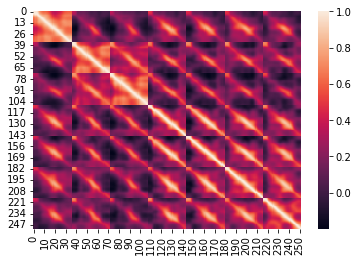

In [41]:
import seaborn as sns

data_corr = pd.DataFrame(X_train_scaled).corr()
sns.heatmap(data_corr)
plt.show()

In [42]:
import seaborn as sns
#sns.heatmap(pca.components_)
#print(sum(pca.components_[:,0]**2))

pca_map=pd.DataFrame(pca.components_,columns=feature_names,index=np.arange(1,253))
#pca.components_.shape
pca_map

ValueError: Shape of passed values is (252, 252), indices imply (252, 72)

In [ ]:
plt.plot(pca.components_[0,:])
x=np.where(pca.components_[0,:]>0.085)
x=np.array(x)
for i in x[0]:
    plt.scatter(x,pca.components_[0,x],c='r',label=feature_names[i])   
#plt.legend()
plt.show()

In [ ]:
plt.plot(pca.components_[2,:])

In [ ]:
plt.plot(pca.components_[1,:])
x=np.where(pca.components_[1,:]>0.085)
x=np.array(x)
for i in x[0]:
    plt.scatter(x,pca.components_[1,x],c='r',label=feature_names[i])   
#plt.legend()
plt.show()

In [ ]:
#USE SVM linear model
svm = SVC(kernel='linear')
svm.fit(X_train_scaled,data_train_target)
print(f'The Score for Training data with SVM Linear Model for all subjects:',svm.score(X_train_scaled,data_train_target))
print(f'Score of For Test data with SVM Linear Model for all subjects : {svm.score(X_test_scaled,data_test_target)}')

try to use pca features to do classification.
I would like to know which features are useful to distinguish each classification.

In [ ]:
#Use RBF model
svm = SVC(kernel='rbf')
svm.fit(X_train_scaled,data_train_target)
print(f'The Score for Training data with SVM RBF Model for all subjects:',svm.score(X_train_scaled,data_train_target))
print(f'Score of For Test datawith SVM RBF Model for all subjects : {svm.score(X_test_scaled,data_test_target)}')

In [ ]:
svm = SVC(kernel='rbf')
svm.fit(X_train_pca[:,0:30],data_train_target)
print(f'The Score for Training data with SVM RBF Model for all subjects:',svm.score(X_train_pca[:,0:30],data_train_target))
print(f'Score of For Test data with SVM RBF Model for all subjects : {svm.score(X_test_pca[:,0:30],data_test_target)}')

In [ ]:
#Try KNN Model
from sklearn.neighbors import KNeighborsClassifier
neighbor = KNeighborsClassifier(n_neighbors=3)
neighbor.fit(X_train_scaled,data_train_target)
print("the score for training with data from 5 participants:",neighbor.score(X_train_scaled,data_train_target))
print("the score for test data from 5 participants:",neighbor.score(X_test_scaled,data_test_target))

In [ ]:
neighbor.fit(X_train_pca[:,0:30],data_train_target)
print("the score for training with data from 5 participants:",neighbor.score(X_train_pca[:,0:30],data_train_target))
print("the score for test data from 5 participants:",neighbor.score(X_test_pca[:,0:30],data_test_target))

In [ ]:
# decision trees
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=16)
dt.fit(X_train_scaled,data_train_target)
print(f"the score for training with data from 5 participants:{dt.score(X_train_scaled,data_train_target)}")
print("the score for test data from 5 participants:",dt.score(X_test_scaled,data_test_target))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_scores = []
test_scores = []
for depth in range(1,35):
    dt_reg = RandomForestClassifier(max_depth=depth,random_state=0)
    dt_reg.fit(X_train_scaled,data_train_target)
    train_scores = train_scores +[dt_reg.score(X_train_scaled,data_train_target)]
    test_scores = test_scores + [dt_reg.score(X_test_scaled,data_test_target)]
    
x = list(range(1,35))
plt.plot(x,train_scores,c='r',label='train')
plt.plot(x,test_scores,c='b',label='test')
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.title('Depth vs. Accuracy for Random Forest Classifier')
plt.show()

In [ ]:
#from sklearn import tree

# graphviz.Source takes a graphviz object and turns it into an image. Graphviz is a
# standard graphical library/format for rendering graphs - nodes connected by edges -
# such as our decision tree below.
#graphviz.Source(tree.export_graphviz(dt,feature_names=feature_names))
#r=tree.export_text(dt, feature_names=feature_names)
#print(r)

# Use 5 folds cross validation 

In [ ]:
from sklearn.model_selection import KFold
import tensorflow as tf
tf.random.set_seed(0)
kfold = KFold(n_splits=5, shuffle=True)

data_train_target=data_train_target

fold_no = 1

score_tr=[]
score_cv=[]

svm = SVC(kernel='rbf')

for train,cv in kfold.split(X_train_scaled,data_train_target):
    X_tr = X_train_scaled[train]
    Y_tr = data_train_target[train]
    X_cv = X_train_scaled[cv]
    Y_cv = data_train_target[cv]
    
    tf.random.set_seed(0)
    
    svm.fit(X_tr,Y_tr)
    score_tr.append(svm.score(X_tr,Y_tr))
    score_cv.append(svm.score(X_cv,Y_cv))
    
    print(f'Score for {fold_no} Fold Training: {score_tr[-1]:.3f}')
    print(f'Score for {fold_no} Fold cv    : {score_cv[-1]:.3f}')
    print('----------------------------------')
    fold_no = fold_no + 1
    
print(f'Score of Average For Training: {np.mean(score_tr):.3f}')
print(f'Score of Average For CV.     : {np.mean(score_cv):.3f}')